In [ ]:
!pip install tqdm

In [ ]:
import pandas as pd
from scipy.stats import ttest_ind
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
organ_names = ['Adipose - Visceral (Omentum)','Muscle - Skeletal','Nerve - Tibial','Liver']
folder_names = ['Adipose_Visceral','Muscle_Skeletal','Nerve_Tibial','Liver']

In [ ]:
genes_names_fileName = '/content/drive/My Drive/final_project_B/Data/gene.f.csv'

#Read genes names data file
genes_names_df = pd.read_csv(genes_names_fileName)

In [ ]:
for organ, folder in zip(organ_names, folder_names):
  gene_data_fileName = '/content/drive/My Drive/final_project_B/Data/{}/mat.f.coding.{}.csv'.format(folder, organ)
  pheno_fileName = '/content/drive/My Drive/final_project_B/Data/{}/pheno.f.{}.csv'.format(folder, organ)
  # Read genes data file and transpose
  genes_df = pd.read_csv(gene_data_fileName,index_col=0).T
  # Read Phenotypes data file
  pheno_df = pd.read_csv(pheno_fileName)
  # Merge genes data with the gender column
  df = pd.merge(genes_df,pheno_df[['SAMPID','SEX']],left_index=True,right_on='SAMPID')
  # Create a list of all genes columns names
  genes_columns = df.columns[df.columns.str.contains("ENSG")]
  # Create an empty DataFrame to populate with t-test results for each gene
  res_df = pd.DataFrame(columns=['tissue','gene','t_statistic','p_value'])
  # Run over all genes and perform t-test between males and females
  # Save the results in res_df
  for gene in tqdm(genes_columns):
      res = ttest_ind(df.loc[df['SEX']==1, gene],df.loc[df['SEX']==2, gene])
      res_df = pd.concat([res_df,pd.DataFrame([{'tissue':organ,'gene':gene,'t_statistic':res[0],'p_value':res[1]}])],ignore_index=True)
  # Display from res_df records for genes with low p_val
  diff_genes_df = res_df[res_df['p_value']<0.02].sort_values('p_value')
  # Filter the relevent genes and convert to csv file
  l = genes_names_df[genes_names_df['Name'].isin(diff_genes_df['gene'])]['Description']
  l.to_csv("/content/drive/My Drive/final_project_B/Data/diff_genes_{}.csv".format(organ), index=False)


  0%|          | 0/18680 [00:00<?, ?it/s]

<ipython-input-14-f9ea6538fd1e>:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res_df = pd.concat([res_df,pd.DataFrame([{'tissue':organ,'gene':gene,'t_statistic':res[0],'p_value':res[1]}])],ignore_index=True)


  0%|          | 0/18680 [00:00<?, ?it/s]

<ipython-input-14-f9ea6538fd1e>:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res_df = pd.concat([res_df,pd.DataFrame([{'tissue':organ,'gene':gene,'t_statistic':res[0],'p_value':res[1]}])],ignore_index=True)


  0%|          | 0/14662 [00:00<?, ?it/s]

<ipython-input-14-f9ea6538fd1e>:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res_df = pd.concat([res_df,pd.DataFrame([{'tissue':organ,'gene':gene,'t_statistic':res[0],'p_value':res[1]}])],ignore_index=True)


  0%|          | 0/18680 [00:00<?, ?it/s]

<ipython-input-14-f9ea6538fd1e>:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res_df = pd.concat([res_df,pd.DataFrame([{'tissue':organ,'gene':gene,'t_statistic':res[0],'p_value':res[1]}])],ignore_index=True)


In [ ]:
# Use the machine learning model
def build_gtex_predictor(expression_data, sex_labels):
    # Preprocess the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(expression_data)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, sex_labels, test_size=0.3, random_state=42, stratify=sex_labels
    )

    # Train Random Forest model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Get feature importance
    feature_importance = pd.DataFrame({
        'gene': expression_data.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)

    # Model evaluation
    y_pred = rf_model.predict(X_test)

    # Cross-validation
    cv_scores = cross_val_score(rf_model, X_scaled, sex_labels, cv=5)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance.head(20), x='importance', y='gene')
    plt.title('Top 20 Most Important Genes for Sex Prediction')
    plt.xticks(rotation=45)
    plt.show()

    return {
        'model': rf_model,
        'feature_importance': feature_importance,
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'cv_scores': cv_scores
    }


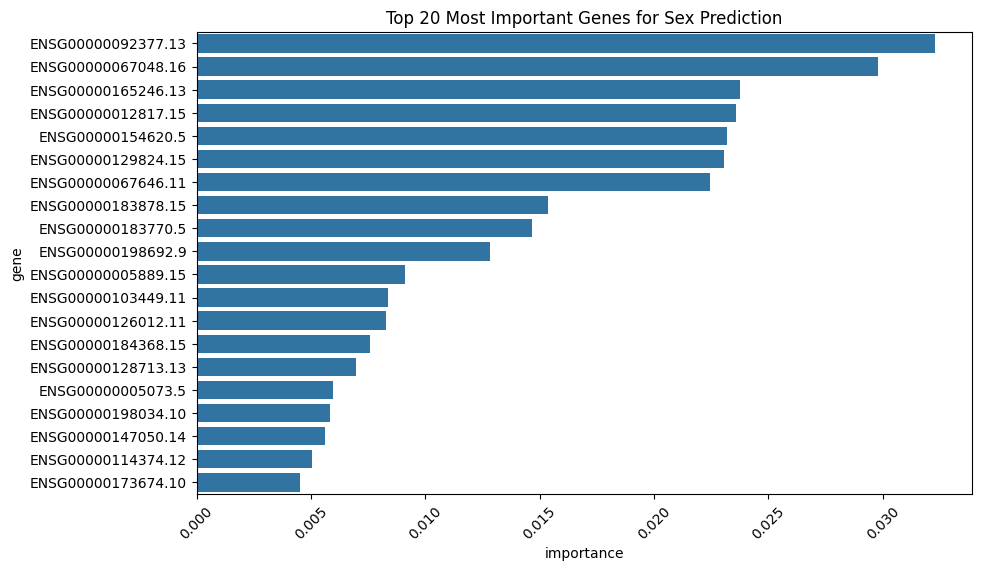

Results for Adipose - Visceral (Omentum):
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       112
           2       1.00      1.00      1.00        51

    accuracy                           1.00       163
   macro avg       1.00      1.00      1.00       163
weighted avg       1.00      1.00      1.00       163

Confusion Matrix:
[[112   0]
 [  0  51]]
Cross-Validation Scores:
[1. 1. 1. 1. 1.]


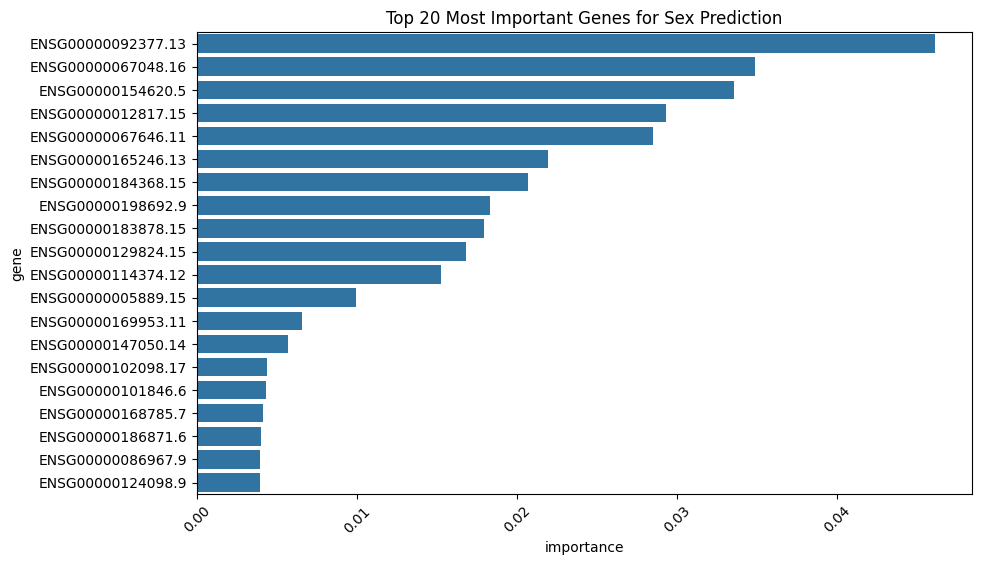

Results for Muscle - Skeletal:
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       163
           2       1.00      1.00      1.00        78

    accuracy                           1.00       241
   macro avg       1.00      1.00      1.00       241
weighted avg       1.00      1.00      1.00       241

Confusion Matrix:
[[163   0]
 [  0  78]]
Cross-Validation Scores:
[1. 1. 1. 1. 1.]


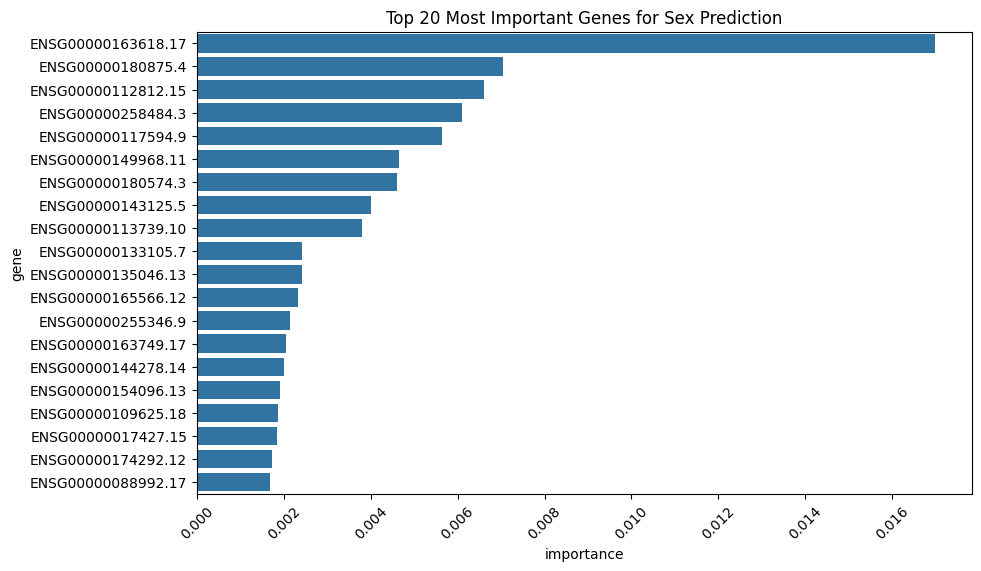

Results for Nerve - Tibial:
Classification Report:
              precision    recall  f1-score   support

           1       0.71      1.00      0.83       126
           2       1.00      0.15      0.26        60

    accuracy                           0.73       186
   macro avg       0.86      0.57      0.55       186
weighted avg       0.80      0.73      0.65       186

Confusion Matrix:
[[126   0]
 [ 51   9]]
Cross-Validation Scores:
[0.69354839 0.68548387 0.71774194 0.68548387 0.7398374 ]


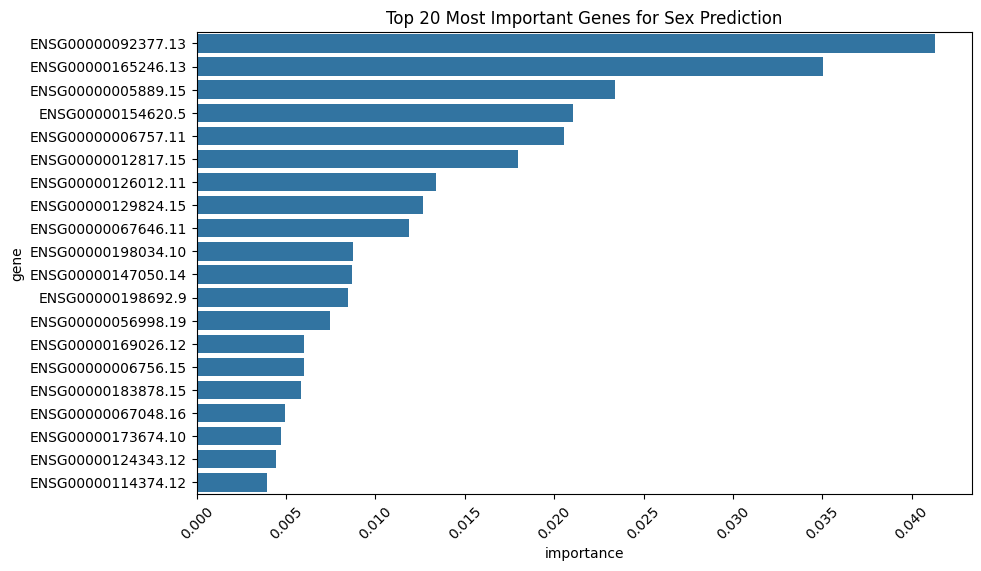

Results for Liver:
Classification Report:
              precision    recall  f1-score   support

           1       0.87      1.00      0.93        48
           2       1.00      0.65      0.79        20

    accuracy                           0.90        68
   macro avg       0.94      0.82      0.86        68
weighted avg       0.91      0.90      0.89        68

Confusion Matrix:
[[48  0]
 [ 7 13]]
Cross-Validation Scores:
[0.93478261 1.         1.         0.88888889 0.95555556]


In [ ]:
for organ, folder in zip(organ_names, folder_names):
    # Define file paths
    gene_data_fileName = f'/content/drive/My Drive/final_project_B/Data/{folder}/mat.f.coding.{organ}.csv'
    pheno_fileName = f'/content/drive/My Drive/final_project_B/Data/{folder}/pheno.f.{organ}.csv'

    # Read genes data file and transpose
    genes_df = pd.read_csv(gene_data_fileName, index_col=0).T
    # Read Phenotypes data file
    pheno_df = pd.read_csv(pheno_fileName)
    # Merge genes data with the gender column
    df = pd.merge(genes_df, pheno_df[['SAMPID', 'SEX']], left_index=True, right_on='SAMPID')

    # Create a list of all genes columns names
    genes_columns = df.columns[df.columns.str.contains("ENSG")]

    # Prepare data for machine learning
    filtered_expression_data = df[genes_columns]
    sex_labels = df['SEX']

    # Build the predictor
    results = build_gtex_predictor(filtered_expression_data, sex_labels)

    # Save or display results
    print(f"Results for {organ}:")
    print("Classification Report:")
    print(results['classification_report'])

    print("Confusion Matrix:")
    print(results['confusion_matrix'])

    print("Cross-Validation Scores:")
    print(results['cv_scores'])

    # Save feature importance
    results['feature_importance'].to_csv(f"/content/drive/My Drive/final_project_B/Data/feature_importance_{organ}.csv", index=False)

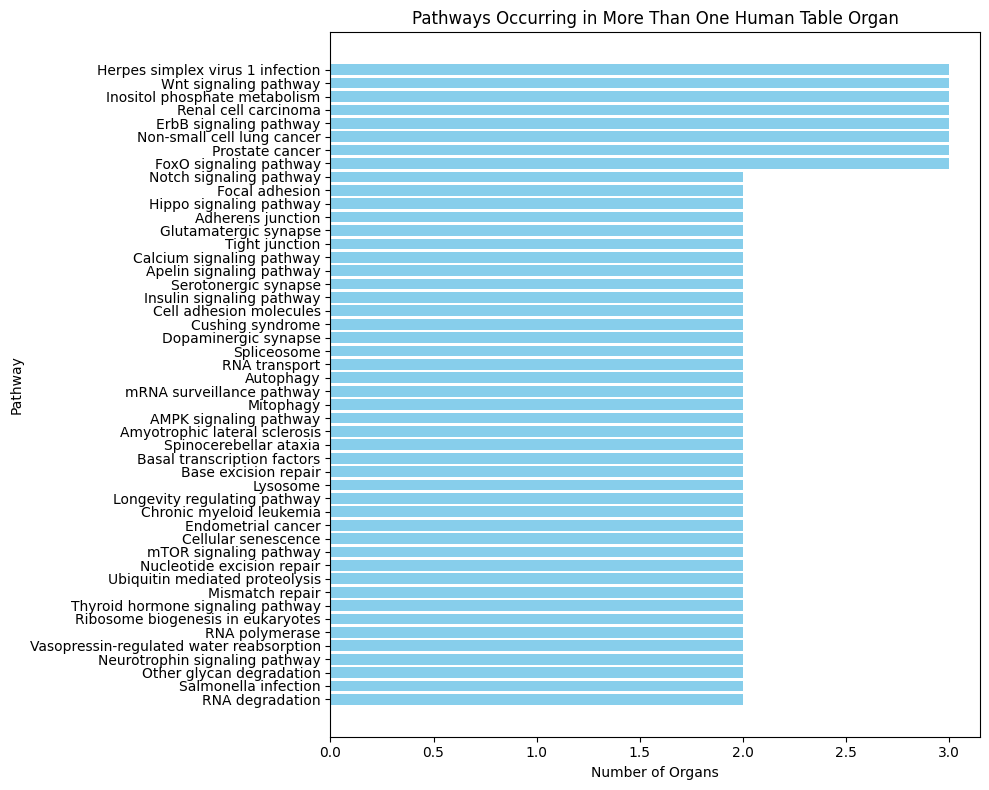

In [ ]:
organ_names = ['Adipose - Visceral (Omentum)','Muscle - Skeletal','Nerve - Tibial','Liver']
folder_names = ['Adipose_Visceral','Muscle_Skeletal','Nerve_Tibial','Liver']# Dictionary to store terms and their associated organs
term_to_organs = defaultdict(list)

for organ in organ_names:
    # Format the file path with the organ name
    kegg_file = f'/content/drive/MyDrive/final_project_B/Data/KEGG_2021_Human_table_{organ}.csv'

    # Read the KEGG file into a DataFrame
    kegg_df = pd.read_csv(kegg_file)
    # Convert P-value to numeric and sort
    kegg_df['P-value'] = pd.to_numeric(kegg_df['P-value'], errors='coerce')
    kegg_df = kegg_df.sort_values('P-value').head(50)  # Top 50 pathways
    # Extract valid terms
    terms = kegg_df['Term']

    # Record each term along with the current organ
    for term in terms:
        term_to_organs[term].append(organ)

# Identify terms present in more than one organ
common_terms = {term: organs for term, organs in term_to_organs.items() if len(organs) > 1}

# Prepare data for the chart
pathways = list(common_terms.keys())
organ_counts = [len(organs) for organs in common_terms.values()]

# Sort pathways by count for better visualization
sorted_indices = sorted(range(len(organ_counts)), key=lambda i: organ_counts[i], reverse=True)
pathways = [pathways[i] for i in sorted_indices]
organ_counts = [organ_counts[i] for i in sorted_indices]

# Create a horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(pathways, organ_counts, color='skyblue')

# Add labels and title
plt.xlabel('Number of Organs')
plt.ylabel('Pathway')
plt.title('Pathways Occurring in More Than One Human Table Organ')
plt.gca().invert_yaxis()  # Show top pathways at the top
plt.tight_layout()

# Show the chart
plt.show()

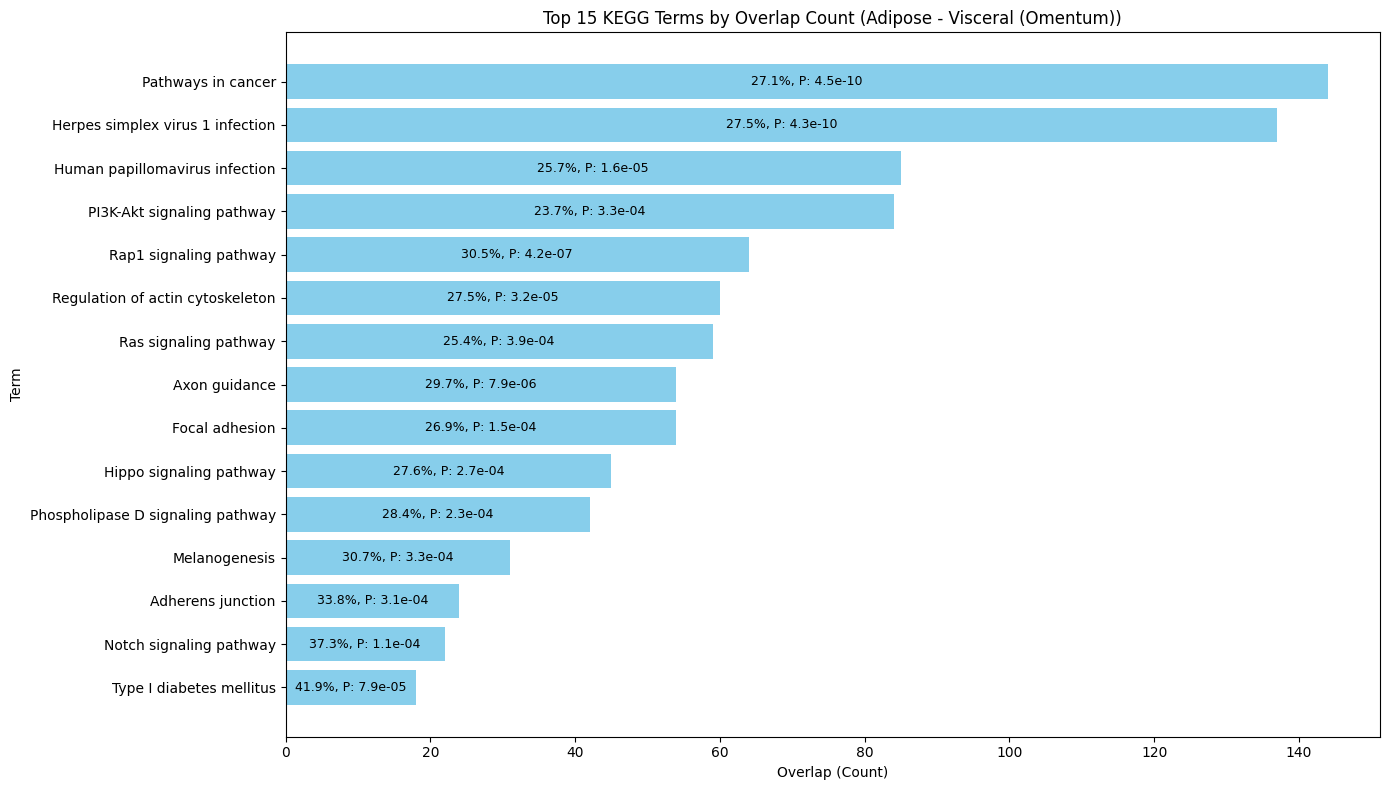

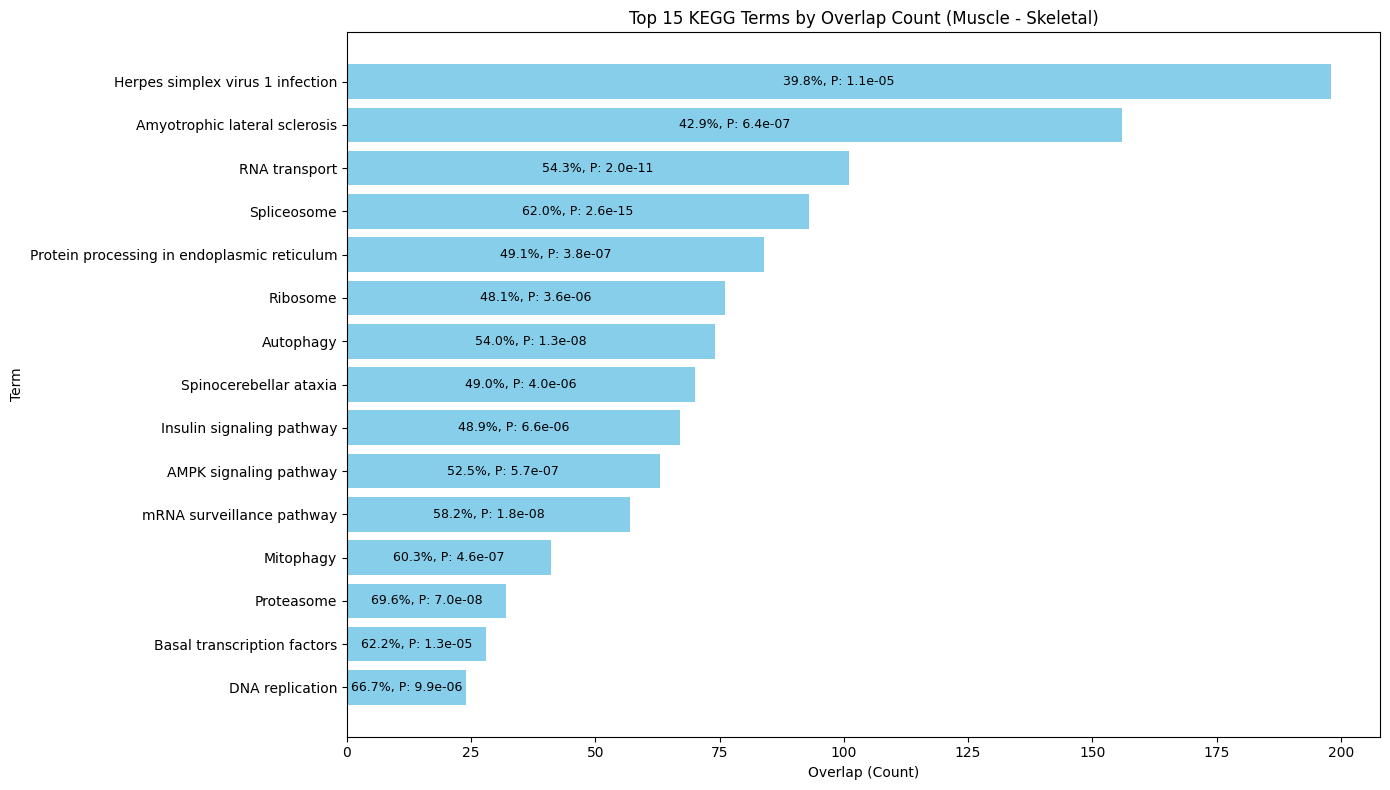

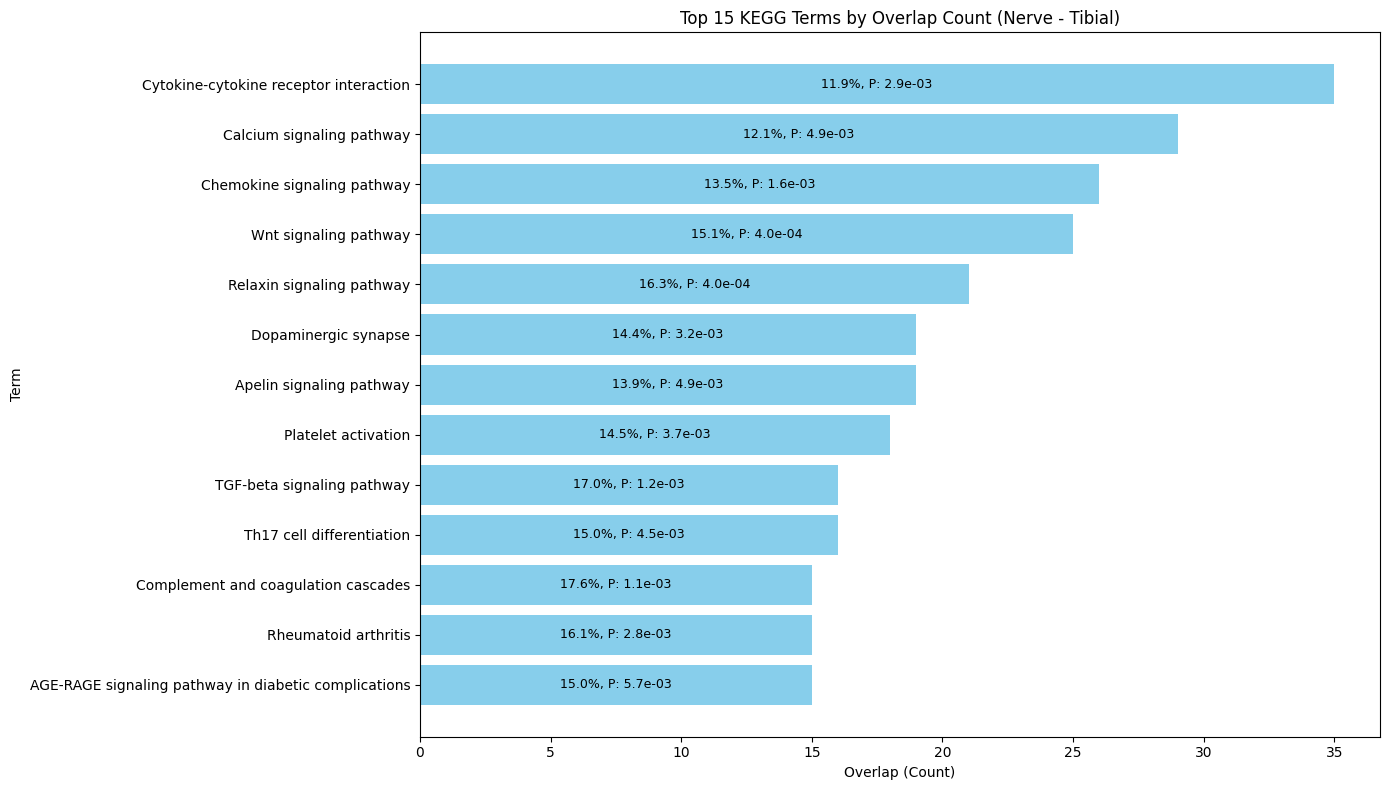

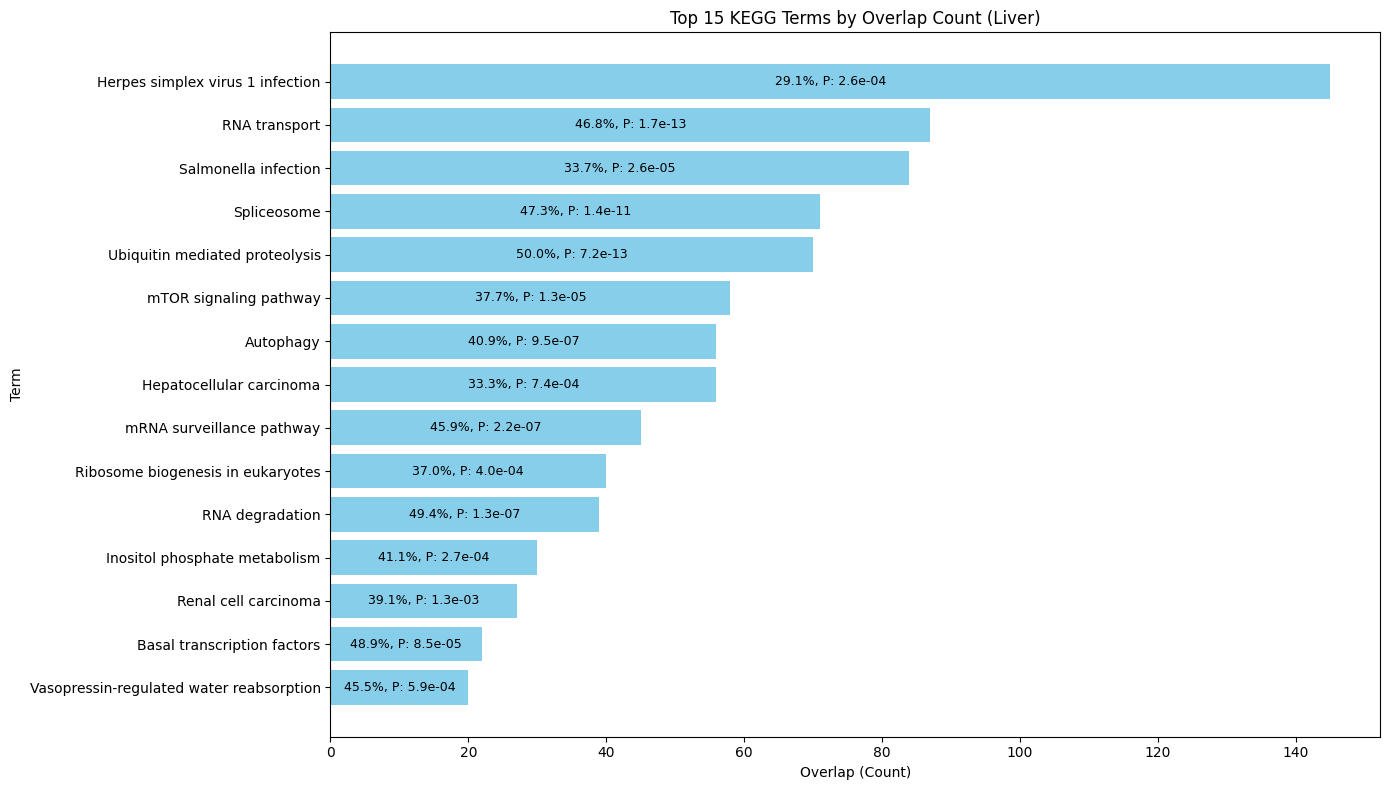

In [ ]:
# Visualize KEGG data
for organ in organ_names:
    # Format the file path with the organ name
    kegg_file = f'/content/drive/MyDrive/final_project_B/Data/KEGG_2021_Human_table_{organ}.csv'

    # Read the KEGG file into a DataFrame
    kegg_df = pd.read_csv(kegg_file)

    # Convert P-value to numeric and sort by it
    kegg_df['P-value'] = pd.to_numeric(kegg_df['P-value'], errors='coerce')
    kegg_df = kegg_df.sort_values('P-value').head(15)

    # Extract relevant columns
    terms = kegg_df['Term']
    overlaps = kegg_df['Overlap']
    p_values = kegg_df['P-value']

    # Filter valid overlap values in the "number/number" format
    valid_overlaps = overlaps[overlaps.str.contains(r'^\d+/\d+$', na=False)]

    # Extract the numerator and denominator from valid overlaps
    overlap_numerators = valid_overlaps.str.split('/').str[0].astype(int)
    overlap_denominators = valid_overlaps.str.split('/').str[1].astype(int)
    overlap_percentages = (overlap_numerators / overlap_denominators) * 100

    # Combine relevant data into a DataFrame for sorting
    valid_data = pd.DataFrame({
        'Term': terms[overlaps.index.isin(valid_overlaps.index)],
        'Overlap': valid_overlaps,
        'Numerator': overlap_numerators,
        'Percentage': overlap_percentages,
        'P-value': p_values[overlaps.index.isin(valid_overlaps.index)]
    })

    # Sort by the overlap numerator
    valid_data = valid_data.sort_values('Numerator', ascending=False)

    # Create a horizontal bar chart
    plt.figure(figsize=(14, 8))
    bars = plt.barh(valid_data['Term'], valid_data['Numerator'], color='skyblue')

    # Add Overlap values, percentages, and P-values on the bars
    for bar, overlap, percentage, p in zip(bars, valid_data['Overlap'], valid_data['Percentage'], valid_data['P-value']):
        plt.text(
            bar.get_width() / 2,  # Position the text at the center of the bar
            bar.get_y() + bar.get_height() / 2,  # Align vertically at the bar center
            f"{percentage:.1f}%, P: {p:.1e}",
            ha='center', va='center', fontsize=9, color='black'
        )

    # Add labels and title
    plt.xlabel('Overlap (Count)')
    plt.ylabel('Term')
    plt.title(f'Top 15 KEGG Terms by Overlap Count ({organ})')
    plt.gca().invert_yaxis()
    plt.tight_layout()

    # Show the chart
    plt.show()
